# Description
- Import the data
- Segment data into 2 turn segments
- Calculate the FFT
- Solve for the DFT ratio
- Calculate the SVD of the dft ratio, dft(strain), dft(angular velocity).
- Genrate scatter plots

## Import Packages

In [3]:
# For calculating derivatives and integrals
import math
import pynumdiff
import scipy
import cvxpy as cp
import umap#.umap_ as umap
from sklearn.preprocessing import StandardScaler

# For processing data
import numpy as np
import pandas as pd

# For calculating frequency content
from scipy import fft
from scipy import signal

# For plotting signals
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

2023-07-26 15:57:39,001 [INFO] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-07-26 15:57:39,002 [INFO] NumExpr defaulting to 8 threads.


# Functions

In [4]:
# Perform a mean subtraction to ensure data is centered around the zero.
def sig_mean_df(df, columns,time):
    df_mean = pd.DataFrame(columns=columns)
    for i in range(len(columns)):
        signal = df[columns[i]]
        signal_mean = np.mean(signal)
        signal_use = (signal-signal_mean)
        df_mean[columns[i]] = signal_use
    df_mean[time] = df[time]
    
    return(df_mean)

# Smooth your data like butter. Return original dataframe with smoothed data appended.
def smooth_butter(df, params, dt, col_names):
    for i in range(np.size(col_names)):
        df[col_names[i] + '_hat'], df[col_names[i] + '_dt'] = pynumdiff.smooth_finite_difference.butterdiff(df[col_names[i]], dt, params, options={'iterate': False})
    return(df)

# Smooth your data and return only smooth signals.
def smooth_only(df, params, dt, col_names):
    df_new = pd.DataFrame()
    for i in range(len(col_names)):
        smooth_data, smooth_derivative = pynumdiff.smooth_finite_difference.butterdiff(df[col_names[i]], dt, params, options={'iterate': False})
        df_new[col_names[i]] = smooth_data 
    return(df_new)

# Calculate the DFT of a data set and return a data frame including the DFT data
def simple_fft_array(array,dt):
    fft_df = pd.DataFrame()
    N = np.shape(array)[0]
    yf = 2.0/N * np.abs(fft.fft(array)[0:N//2])
    xf = fft.fftfreq(N,dt)[:N//2]
    fft_df['array_fft'] = yf
    fft_df['frequency'] = xf
    return(fft_df)

# Take the FFT of a dataset and return a new data frame containing the DFT data.
def fft_of_data_df(df,dt,columns):
    fft_df = pd.DataFrame()
    for i in range(len(columns)):
        data = df[columns[i]]
        data = np.array(data)
        N = data.shape[0] # Length of data.
        yf = 2.0/N * np.abs(fft.fft(data)[0:N//2])# Divide to bring the manitude to the magnitude of the orginal sinewave.
        # Remember the the y-data will be complex so you have to take the absolute value.
        xf = fft.fftfreq(N,dt)[:N//2]# Only take the first half of the data.
        fft_df[columns[i]+'_fft'] = yf
        if i == len(columns)-1:
            fft_df['Frequency'] = xf
    return(fft_df)

# Use query to extract segments of data.
def segment_data(df, column_title, lower_lim, upper_lim):
    q = column_title + ' < ' + str(upper_lim) + ' and ' + column_title + ' > ' + str(lower_lim)
    new_df = df.query(q)
    return(new_df)

# Segment the data into desired segment size and take the FFT of the signals
# Return a new data frame.
def segment_create_new_df_for_each_sg(list_of_dfs,strain_gauge,chunck_size,snow_types,dt):
    lower_freq = 1/60
    high_freq = 150
    df_new = pd.DataFrame()
#     dataframes = np.shape(list_of_dfs[0])[0]
    data_frames = len(snow_types)-1
    for j in range(data_frames):
            df_column = list_of_dfs[j][strain_gauge]
            n = len(df_column)//chunk_size
            for i in range(n):
                data = df_column[i*chunk_size:(i+1)*chunk_size] # "data" is the segmented timeseries. 
                df_new[df_column.name+'_'+str(i+1)+'_'+snow_types[j]] = data.reset_index(drop=True)
    df_new = fft_of_data_df(df_new,dt,df_new.columns.tolist())
    # Take every 5th entry.
    df_new = segment_data(df_new,'Frequency',lower_freq,high_freq) #.iloc[0::2,:].reset_index(drop=True)
    return(df_new)

## Code

## 1.0 Load data and format data

In [5]:
# Import ski data
df_grmr = pd.read_hdf('DATA/df_grmr.hdf')
df_grmr1 = pd.read_hdf('DATA/df_grmr1.hdf')
df_grmr2 = pd.read_hdf('DATA/df_grmr2.hdf')
df_grmr3 = pd.read_hdf('DATA/df_grmr3.hdf')
df_grmr4 = pd.read_hdf('DATA/df_grmr4.hdf')
df_grmr5 = pd.read_hdf('DATA/df_grmr5.hdf')

df_pwdr = pd.read_hdf('DATA/df_pwdr.hdf')
df_pwdr1 = pd.read_hdf('DATA/df_pwdr1.hdf')

df_icy = pd.read_hdf('DATA/df_icy.hdf')

df_s = pd.read_hdf('DATA/df_s.hdf')
df_s1 = pd.read_hdf('DATA/df_s1.hdf')
df_s2 = pd.read_hdf('DATA/df_s2.hdf')
df_s3 = pd.read_hdf('DATA/df_s3.hdf')

In [6]:
# Create data frames that are mean subtracted.
columns = ['sg3','sg4','sg6','sgc','sg7','sg12','sg15','imu_ax','imu_ay','imu_az','imu_wx','imu_wy','imu_wz'] # Columns to use.
df_grmr_mean  = sig_mean_df(df_grmr,columns,'time_imu')
df_grmr1_mean = sig_mean_df(df_grmr1,columns,'time_imu')
df_grmr2_mean = sig_mean_df(df_grmr2,columns,'time_imu')
df_grmr3_mean = sig_mean_df(df_grmr3,columns,'time_imu')
df_grmr4_mean = sig_mean_df(df_grmr4,columns,'time_imu')
df_grmr5_mean = sig_mean_df(df_grmr5,columns,'time_imu')
df_pwdr_mean  = sig_mean_df(df_pwdr,columns,'time_imu')
df_pwdr1_mean = sig_mean_df(df_pwdr1,columns,'time_imu')
df_icy_mean   = sig_mean_df(df_icy,columns,'time_imu')
df_s_mean     = sig_mean_df(df_s,columns,'time_imu')
df_s1_mean    = sig_mean_df(df_s1,columns,'time_imu')
df_s2_mean    = sig_mean_df(df_s2,columns,'time_imu')
df_s3_mean    = sig_mean_df(df_s3,columns,'time_imu')
all_mean_time = [df_grmr_mean,df_grmr1_mean,df_grmr2_mean,df_grmr3_mean,df_grmr4_mean,df_grmr5_mean,
                df_pwdr_mean,df_pwdr1_mean,
                df_icy_mean,
                df_s_mean,df_s1_mean,df_s2_mean,df_s3_mean]

## 1.1 Plot strain and smoothed angular velocity data

## 1.2 Segment the data
- Segment into 2 turn segments
- Take the FFT of the data

In [7]:
# Segment the original non normalized strain data.
# And take the FFT of the signals.
dt = 0.001 # Sample period
snow_types = ['groomer_slow','groomer_slow1','groomer_fast','groomer_fast1','groomer_slow2','groomer_fast2','powder_1',
              'powder_5','icy_fast','icy1_fast','slushy_fast','slushy_slow','slushy_fast1','slushy_slow1']
strain_gauge = ['sg3','sg4','sg12','sg6','sgc','sg7','sg15']
chunk_size = 10000
sg3_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[0],chunk_size,snow_types,dt)
sg4_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[1],chunk_size,snow_types,dt)
sg12_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[2],chunk_size,snow_types,dt)
sg6_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[3],chunk_size,snow_types,dt)
sgc_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[4],chunk_size,snow_types,dt)
sg7_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[5],chunk_size,snow_types,dt)
sg15_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[6],chunk_size,snow_types,dt)

strain_segmented_all_fft = [sg3_segmented_all_snow.iloc[:,0:65],sg12_segmented_all_snow.iloc[:,0:65],sg6_segmented_all_snow.iloc[:,0:65],
                           sgc_segmented_all_snow.iloc[:,0:65],sg7_segmented_all_snow.iloc[:,0:65],sg15_segmented_all_snow.iloc[:,0:65]]

ang_velx_all_snow = segment_create_new_df_for_each_sg(all_mean_time,'imu_wx',chunk_size,snow_types,dt)
ang_vely_all_snow = segment_create_new_df_for_each_sg(all_mean_time,'imu_wy',chunk_size,snow_types,dt)
ang_velz_all_snow = segment_create_new_df_for_each_sg(all_mean_time,'imu_wz',chunk_size,snow_types,dt)

angular_vel_all = [ang_velx_all_snow,ang_vely_all_snow,ang_velz_all_snow]

## 1.3 Solve for the DFT ratio 
- Do this using various "inputs"
- Inputs are the 3 axes of angular velocity measured from the IMU

In [8]:
# Calculate the DFT ratio for x axis
gamma = 0.8 # Weighting parameter for total variance constraint.
all_b3 = []
all_b12 = []
all_b6 = []
all_bc = []
all_b7 = []
all_b15 = []

for i in range(np.shape(ang_velx_all_snow)[1]-1):
    in_data = np.array(ang_velx_all_snow.iloc[:,i]).reshape((np.shape(ang_velx_all_snow.iloc[:,i])[0],1)) # The input will be the same across all strain gauges.
    out_data3 = np.array(sg3_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg3_segmented_all_snow.iloc[:,i])[0],1))
    out_data12 = np.array(sg12_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg12_segmented_all_snow.iloc[:,i])[0],1))
    out_data6 = np.array(sg6_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg6_segmented_all_snow.iloc[:,i])[0],1))
    out_datac = np.array(sgc_segmented_all_snow.iloc[:,i]).reshape((np.shape(sgc_segmented_all_snow.iloc[:,i])[0],1))
    out_data7 = np.array(sg7_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg7_segmented_all_snow.iloc[:,i])[0],1))
    out_data15 = np.array(sg15_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg15_segmented_all_snow.iloc[:,i])[0],1))

    bode3 = cp.Variable(np.shape(in_data)[0]) # Numerical bode plot that resets every time, but the values are appended. 
    bode12 = cp.Variable(np.shape(in_data)[0])
    bode6 = cp.Variable(np.shape(in_data)[0])
    bodec = cp.Variable(np.shape(in_data)[0])
    bode7 = cp.Variable(np.shape(in_data)[0])
    bode15 = cp.Variable(np.shape(in_data)[0])

    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode3) - out_data3[:,0])) + gamma*cp.tv(bode3)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b3.append(bode3.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode12) - out_data12[:,0])) + gamma*cp.tv(bode12)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b12.append(bode12.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode6) - out_data6[:,0])) + gamma*cp.tv(bode6)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b6.append(bode6.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bodec) - out_datac[:,0])) + gamma*cp.tv(bodec)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_bc.append(bodec.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode7) - out_data7[:,0])) + gamma*cp.tv(bode7)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b7.append(bode7.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode15) - out_data15[:,0])) + gamma*cp.tv(bode15)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b15.append(bode15.value)
    
all_bode_datax = [np.transpose(all_b3),np.transpose(all_b12),np.transpose(all_b6),np.transpose(all_bc),np.transpose(all_b7),np.transpose(all_b15)]

In [9]:
np.shape(all_bode_datax[0][:,0])

(1499,)

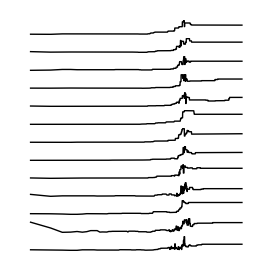

In [10]:
iterations = 13#np.shape(all_bode_datax[0])[1]
mpl.rc('font', size=8)
fig, ax = plt.subplots(iterations,1,figsize=[1.5,1.5],dpi=200)
fig.subplots_adjust(hspace=0.2)
fig.patch.set_facecolor('white')

ax = ax.ravel()
for j in range(iterations):
    ax[j].plot(sg3_segmented_all_snow.Frequency,all_bode_datax[0][:,j], color = 'black',linewidth=0.5)
    ax[j].set_xscale('log')
    ax[j].axis('off')
    if j == iterations-1:
        ax[j].axes.yaxis.set_visible(True)
        ax[j].set_xlabel('Frequency, [Hz]')
    else:
        ax[j].axes.xaxis.set_visible(False)
        ax[j].axes.yaxis.set_visible(False)

# plt.savefig("images/x_bode_stack.svg",bbox_inches='tight',dpi=fig.dpi)
plt.show()

In [11]:
# Y axis
all_b3 = []
all_b12 = []
all_b6 = []
all_bc = []
all_b7 = []
all_b15 = []

for i in range(np.shape(ang_vely_all_snow)[1]-1):
    in_data = np.array(ang_vely_all_snow.iloc[:,i]).reshape((np.shape(ang_vely_all_snow.iloc[:,i])[0],1)) # The input will be the same across all strain gauges.
    out_data3 = np.array(sg3_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg3_segmented_all_snow.iloc[:,i])[0],1))
    out_data12 = np.array(sg12_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg12_segmented_all_snow.iloc[:,i])[0],1))
    out_data6 = np.array(sg6_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg6_segmented_all_snow.iloc[:,i])[0],1))
    out_datac = np.array(sgc_segmented_all_snow.iloc[:,i]).reshape((np.shape(sgc_segmented_all_snow.iloc[:,i])[0],1))
    out_data7 = np.array(sg7_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg7_segmented_all_snow.iloc[:,i])[0],1))
    out_data15 = np.array(sg15_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg15_segmented_all_snow.iloc[:,i])[0],1))

    bode3 = cp.Variable(np.shape(in_data)[0]) # Numerical bode plot that resets every time, but the values are appended. 
    bode12 = cp.Variable(np.shape(in_data)[0])
    bode6 = cp.Variable(np.shape(in_data)[0])
    bodec = cp.Variable(np.shape(in_data)[0])
    bode7 = cp.Variable(np.shape(in_data)[0])
    bode15 = cp.Variable(np.shape(in_data)[0])

    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode3) - out_data3[:,0])) + gamma*cp.tv(bode3)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b3.append(bode3.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode12) - out_data12[:,0])) + gamma*cp.tv(bode12)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b12.append(bode12.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode6) - out_data6[:,0])) + gamma*cp.tv(bode6)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b6.append(bode6.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bodec) - out_datac[:,0])) + gamma*cp.tv(bodec)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_bc.append(bodec.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode7) - out_data7[:,0])) + gamma*cp.tv(bode7)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b7.append(bode7.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode15) - out_data15[:,0])) + gamma*cp.tv(bode15)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b15.append(bode15.value)

all_bode_datay = [np.transpose(all_b3),np.transpose(all_b12),np.transpose(all_b6),np.transpose(all_bc),np.transpose(all_b7),np.transpose(all_b15)]

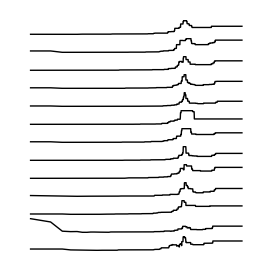

In [12]:
iterations = 13#np.shape(all_bode_datay[0])[1]
mpl.rc('font', size=8)
fig, ax = plt.subplots(iterations,1,figsize=[1.5,1.5],dpi=200)
fig.subplots_adjust(hspace=0.2)
fig.patch.set_facecolor('white')

ax = ax.ravel()
for j in range(iterations):
    ax[j].plot(sg3_segmented_all_snow.Frequency,all_bode_datay[0][:,j], color = 'black',linewidth=0.5)
    ax[j].set_xscale('log')
    ax[j].axis('off')
    if j == iterations-1:
        ax[j].axes.yaxis.set_visible(True)
        ax[j].set_xlabel('Frequency, [Hz]')
    else:
        ax[j].axes.xaxis.set_visible(False)
        ax[j].axes.yaxis.set_visible(False)

# plt.savefig("images/y_bode_stack.svg",bbox_inches='tight',dpi=fig.dpi)
plt.show()

In [13]:
# Z axis
all_b3 = []
all_b12 = []
all_b6 = []
all_bc = []
all_b7 = []
all_b15 = []

for i in range(np.shape(ang_velz_all_snow)[1]-1):
    in_data = np.array(ang_velz_all_snow.iloc[:,i]).reshape((np.shape(ang_velz_all_snow.iloc[:,i])[0],1)) # The input will be the same across all strain gauges.
    out_data3 = np.array(sg3_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg3_segmented_all_snow.iloc[:,i])[0],1))
    out_data12 = np.array(sg12_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg12_segmented_all_snow.iloc[:,i])[0],1))
    out_data6 = np.array(sg6_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg6_segmented_all_snow.iloc[:,i])[0],1))
    out_datac = np.array(sgc_segmented_all_snow.iloc[:,i]).reshape((np.shape(sgc_segmented_all_snow.iloc[:,i])[0],1))
    out_data7 = np.array(sg7_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg7_segmented_all_snow.iloc[:,i])[0],1))
    out_data15 = np.array(sg15_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg15_segmented_all_snow.iloc[:,i])[0],1))

    bode3 = cp.Variable(np.shape(in_data)[0]) # Numerical bode plot that resets every time, but the values are appended. 
    bode12 = cp.Variable(np.shape(in_data)[0])
    bode6 = cp.Variable(np.shape(in_data)[0])
    bodec = cp.Variable(np.shape(in_data)[0])
    bode7 = cp.Variable(np.shape(in_data)[0])
    bode15 = cp.Variable(np.shape(in_data)[0])

    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode3) - out_data3[:,0])) + gamma*cp.tv(bode3)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b3.append(bode3.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode12) - out_data12[:,0])) + gamma*cp.tv(bode12)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b12.append(bode12.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode6) - out_data6[:,0])) + gamma*cp.tv(bode6)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b6.append(bode6.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bodec) - out_datac[:,0])) + gamma*cp.tv(bodec)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_bc.append(bodec.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode7) - out_data7[:,0])) + gamma*cp.tv(bode7)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b7.append(bode7.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode15) - out_data15[:,0])) + gamma*cp.tv(bode15)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b15.append(bode15.value)
    
all_bode_dataz = [np.transpose(all_b3),np.transpose(all_b12),np.transpose(all_b6),np.transpose(all_bc),np.transpose(all_b7),np.transpose(all_b15)]

# Stack all the ratios together to take advantage of all three axes. 
all_bode_data = np.hstack((all_bode_datax,all_bode_datay,all_bode_dataz))

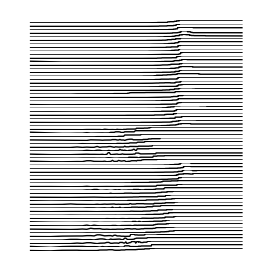

In [14]:
iterations = np.shape(all_bode_dataz[0])[1]
mpl.rc('font', size=8)
fig, ax = plt.subplots(iterations,1,figsize=[1.5,1.5],dpi=200)
fig.subplots_adjust(hspace=0.2)
fig.patch.set_facecolor('white')

ax = ax.ravel()
for j in range(iterations):
    ax[j].plot(sg3_segmented_all_snow.Frequency,all_bode_dataz[0][:,j], color = 'black',linewidth=0.5)
    ax[j].set_xscale('log')
    ax[j].axis('off')
    if j == iterations-1:
        ax[j].axes.yaxis.set_visible(True)
        ax[j].set_xlabel('Frequency, [Hz]')
    else:
        ax[j].axes.xaxis.set_visible(False)
        ax[j].axes.yaxis.set_visible(False)

# plt.savefig("images/z_bode_stack.svg",bbox_inches='tight',dpi=fig.dpi)
plt.show()

In [35]:
A = np.random.random([3,6])

In [53]:
A.T

array([[0.79614368, 0.08411994, 0.75289233],
       [0.70153033, 0.49138634, 0.10618137],
       [0.30313174, 0.04029279, 0.90382144],
       [0.14661484, 0.79264259, 0.3980131 ],
       [0.64630125, 0.74389861, 0.63635399],
       [0.29069426, 0.04652119, 0.60251534]])

In [54]:
Uapp,Sapp,Vapp = np.linalg.svd(A.T)

In [58]:
Vapp.shape

(3, 3)

In [49]:
sg3_segmented_all_snow.Frequency

1         0.1
2         0.2
3         0.3
4         0.4
5         0.5
        ...  
1495    149.5
1496    149.6
1497    149.7
1498    149.8
1499    149.9
Name: Frequency, Length: 1499, dtype: float64

In [50]:
Uapp,Sapp,Vapp = np.linalg.svd(all_bode_dataz[0], full_matrices = False)

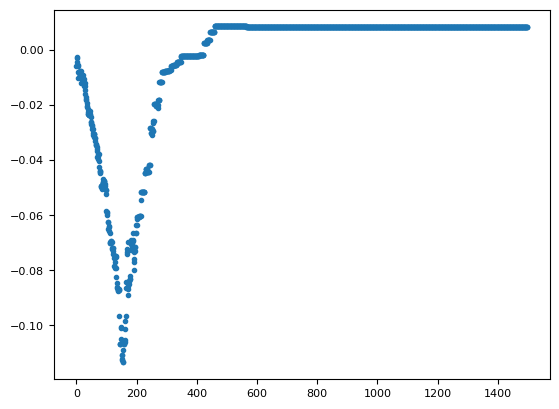

In [52]:
plt.plot(Uapp[:,1], '.')

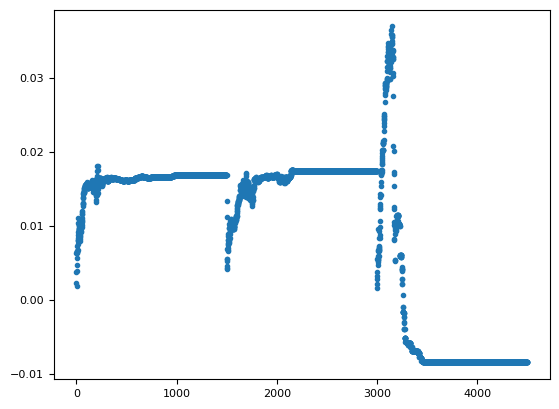

In [48]:
plt.plot(Uapp[:,1], '.')

In [31]:
all_bode_data[0].shape

(4497, 65)

In [34]:
Vapp.shape

(65, 65)

## 2.0 Take the Singular Value Decomposition (SVD) of the ratios.

In [9]:
# SVD of the fft data. This is using all the BODE plots stacked in rows.
U,S,V = [],[],[]
for i in range(np.shape(all_bode_data)[0]):
    Uapp,Sapp,Vapp = np.linalg.svd(all_bode_data[i], full_matrices = False)
    U.append(Uapp)
    S.append(Sapp)
    V.append(Vapp)
    
# SVD of the fft data. This is using the x_angular vel. BODE plots stacked in rows.
Ux,Sx,Vx = [],[],[]
for i in range(np.shape(all_bode_datax)[0]):
    Uapp,Sapp,Vapp = np.linalg.svd(all_bode_datax[i], full_matrices = False)
    Ux.append(Uapp)
    Sx.append(Sapp)
    Vx.append(Vapp)
    
# SVD of the fft data. This is using the y_angular vel. BODE plots stacked in rows.
Uy,Sy,Vy = [],[],[]
for i in range(np.shape(all_bode_datay)[0]):
    Uapp,Sapp,Vapp = np.linalg.svd(all_bode_datay[i], full_matrices = False)
    Uy.append(Uapp)
    Sy.append(Sapp)
    Vy.append(Vapp)
    
# SVD of the fft data. This is using the z_angular vel. BODE plots stacked in rows.
Uz,Sz,Vz = [],[],[]
for i in range(np.shape(all_bode_dataz)[0]):
    Uapp,Sapp,Vapp = np.linalg.svd(all_bode_dataz[i], full_matrices = False)
    Uz.append(Uapp)
    Sz.append(Sapp)
    Vz.append(Vapp)
    
# SVD of the original strain gauge fft data.
Usg,Ssg,Vsg = [],[],[]
for i in range(np.shape(strain_segmented_all_fft)[0]):
    Uapp,Sapp,Vapp = np.linalg.svd(strain_segmented_all_fft[i], full_matrices=False)
    Usg.append(Uapp)
    Ssg.append(Sapp)
    Vsg.append(Vapp)
    
# SVD of the input angular velocities. 
Uwx,Swx,Vwx = np.linalg.svd(ang_velx_all_snow.iloc[:,0:65], full_matrices = False)
Uwy,Swy,Vwy = np.linalg.svd(ang_vely_all_snow.iloc[:,0:65], full_matrices = False)
Uwz,Swz,Vwz = np.linalg.svd(ang_velz_all_snow.iloc[:,0:65], full_matrices = False)

In [29]:
np.shape(Uwx)

(1499, 65)

In [30]:
np.shape(Swx)

(65,)

In [31]:
np.shape(Vwx)

(65, 65)

## 2.1 Generate dataframes of the V matrices 

In [10]:
# Create a pandas dataframe for each Strain gauge
Vx_sg3 = pd.DataFrame(Vx[0])
Vx_sg12 = pd.DataFrame(Vx[1])
Vx_sg6 = pd.DataFrame(Vx[2])
Vx_sgc = pd.DataFrame(Vx[3])
Vx_sg7 = pd.DataFrame(Vx[4])
Vx_sg15 = pd.DataFrame(Vx[5])

Vy_sg3 = pd.DataFrame(Vy[0])
Vy_sg12 = pd.DataFrame(Vy[1])
Vy_sg6 = pd.DataFrame(Vy[2])
Vy_sgc = pd.DataFrame(Vy[3])
Vy_sg7 = pd.DataFrame(Vy[4])
Vy_sg15 = pd.DataFrame(Vy[5])

Vz_sg3 = pd.DataFrame(Vz[0])
Vz_sg12 = pd.DataFrame(Vz[1])
Vz_sg6 = pd.DataFrame(Vz[2])
Vz_sgc = pd.DataFrame(Vz[3])
Vz_sg7 = pd.DataFrame(Vz[4])
Vz_sg15 = pd.DataFrame(Vz[5])

# Stacked DFT ratios
V_sg3 = pd.DataFrame(V[0])
V_sg12 = pd.DataFrame(V[1])
V_sg6 = pd.DataFrame(V[2])
V_sgc = pd.DataFrame(V[3])
V_sg7 = pd.DataFrame(V[4])
V_sg15 = pd.DataFrame(V[5])

# Angular velocities 
Vwx_df = pd.DataFrame(Vwx)
Vwy_df = pd.DataFrame(Vwy)
Vwz_df = pd.DataFrame(Vwz)

# Stain DFT data
V_sg3_original = pd.DataFrame(Vsg[0])
V_sg12_original = pd.DataFrame(Vsg[1])
V_sg6_original = pd.DataFrame(Vsg[2])
V_sgc_original = pd.DataFrame(Vsg[3])
V_sg7_original = pd.DataFrame(Vsg[4])
V_sg15_original = pd.DataFrame(Vsg[5])

## 3.0 Reduce data using UMAP
- Generate UMAP object
- Scale
- Calculate projections

In [11]:
# Generate UMAP object
reducer = umap.UMAP()
features = 5# This indexes how many features to feed to the UMAP

## 3.1 Project n dimensions using UMAP

In [12]:
# UMAP of just the strain gague dft
scaled_ski_data = StandardScaler().fit_transform(np.transpose(V_sg3_original.iloc[0:features,0:65]))
embedding3_original = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(V_sg12_original.iloc[0:features,0:65]))
embedding12_original = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(V_sg6_original.iloc[0:features,0:65]))
embedding6_original = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(V_sgc_original.iloc[0:features,0:65]))
embeddingc_original = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(V_sg7_original.iloc[0:features,0:65]))
embedding7_original = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(V_sg15_original.iloc[0:features,0:65]))
embedding15_original = reducer.fit_transform(scaled_ski_data)

# UMAP of the angular velocity V matrices
scaled_ski_data = StandardScaler().fit_transform(np.transpose(Vwx_df.iloc[0:features,0:65]))
embedding_wx = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(Vwy_df.iloc[0:features,0:65]))
embedding_wy = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(Vwz_df.iloc[0:features,0:65]))
embedding_wz = reducer.fit_transform(scaled_ski_data)

embedding_ang_vel = [embedding_wx,embedding_wy,embedding_wz]

# V matrices of the fft ratios
scaled_ski_data = StandardScaler().fit_transform(np.transpose(Vx_sg3.iloc[0:features,0:65]))
embedding3x = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(Vx_sg12.iloc[0:features,0:65]))
embedding12x = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(Vx_sg6.iloc[0:features,0:65]))
embedding6x = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(Vx_sgc.iloc[0:features,0:65]))
embeddingcx = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(Vx_sg7.iloc[0:features,0:65]))
embedding7x = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(Vx_sg15.iloc[0:features,0:65]))
embedding15x = reducer.fit_transform(scaled_ski_data)

scaled_ski_data = StandardScaler().fit_transform(np.transpose(Vy_sg3.iloc[0:features,0:65]))
embedding3y = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(Vy_sg12.iloc[0:features,0:65]))
embedding12y = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(Vy_sg6.iloc[0:features,0:65]))
embedding6y = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(Vy_sgc.iloc[0:features,0:65]))
embeddingcy = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(Vy_sg7.iloc[0:features,0:65]))
embedding7y = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(Vy_sg15.iloc[0:features,0:65]))
embedding15y = reducer.fit_transform(scaled_ski_data)

scaled_ski_data = StandardScaler().fit_transform(np.transpose(Vz_sg3.iloc[0:features,0:65]))
embedding3z = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(Vz_sg12.iloc[0:features,0:65]))
embedding12z = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(Vz_sg6.iloc[0:features,0:65]))
embedding6z = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(Vz_sgc.iloc[0:features,0:65]))
embeddingcz = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(Vz_sg7.iloc[0:features,0:65]))
embedding7z = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(Vz_sg15.iloc[0:features,0:65]))
embedding15z = reducer.fit_transform(scaled_ski_data)

# Embedding dft ratio using all the angular velocity axes.
scaled_ski_data = StandardScaler().fit_transform(np.transpose(V_sg3.iloc[0:features,0:65]))
embedding3 = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(V_sg12.iloc[0:features,0:65]))
embedding12 = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(V_sg6.iloc[0:features,0:65]))
embedding6 = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(V_sgc.iloc[0:features,0:65]))
embeddingc = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(V_sg7.iloc[0:features,0:65]))
embedding7 = reducer.fit_transform(scaled_ski_data)
scaled_ski_data = StandardScaler().fit_transform(np.transpose(V_sg15.iloc[0:features,0:65]))
embedding15 = reducer.fit_transform(scaled_ski_data)

embeddingx = [embedding3x,embedding12x,embedding6x,embeddingcx,embedding7x,embedding15x]
embeddingy = [embedding3y,embedding12y,embedding6y,embeddingcy,embedding7y,embedding15y]
embeddingz = [embedding3z,embedding12z,embedding6z,embeddingcz,embedding7z,embedding15z]
embedding = [embedding3,embedding12,embedding6,embeddingc,embedding7,embedding15]
##################################################################################################################### Transpose is very important!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
##################################### Make sure your data is oriented correctly!!!!!!!

## 4.0 Generate scatter plots

In [13]:
# Create an array of labels
snow_types0 = ['Groomer']*6*5
snow_types1 = ['Powder']*2*5
snow_types2 = ['Icy']*1*5
snow_types3 = ['Slushy']*4*5
snow_types = np.hstack((snow_types0,snow_types1,snow_types2,snow_types3))

snow_types = pd.Series(snow_types)

In [14]:
styles = ['slow','slow', 'slow', 'slow', 'slow', 'slow', 'slow', 'slow', 'slow', 'slow', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast',
 'fast', 'fast', 'fast', 'slow', 'slow', 'slow', 'slow', 'slow', 'fast', 'fast', 'fast', 'fast', 'fast', 'slow', 'slow', 'slow',
 'slow', 'slow', 'slow', 'slow', 'slow', 'slow', 'slow', 'fast', 'fast', 'fast', 'fast',
 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'slow', 'slow', 'slow', 'slow', 'slow', 'fast', 'fast', 'fast', 'fast', 'fast','slow','slow','slow','slow','slow']

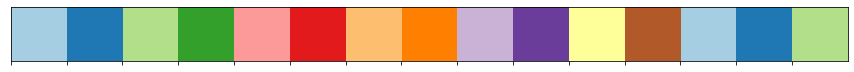

In [15]:
# Save a palette to a variable:
color_p = 'Paired'
color_range = 15
palette = sns.color_palette(color_p,color_range)

# Use palplot and pass in the variable:
sns.palplot(palette)

## 4.1 Scatter plots of the dft ratios

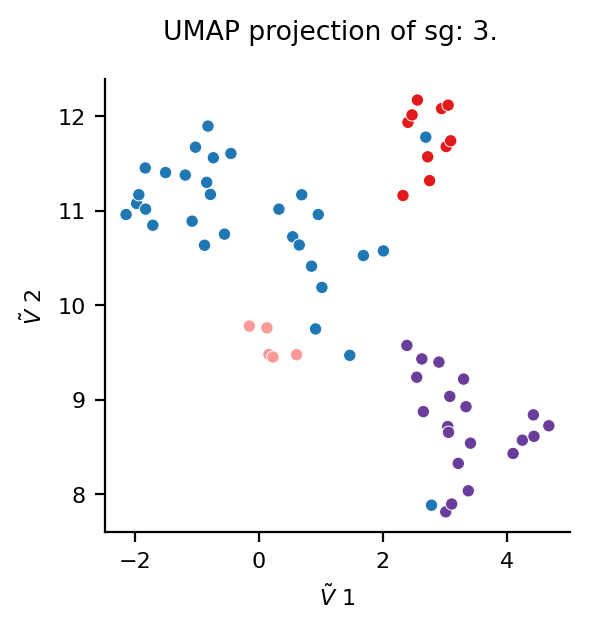

In [16]:
mpl.rc('font', size=8)

#############
sg = 0 # Choose which strain gague to plot
#############

markers = {"slow": "o", "fast": "^"}
fig, ax = plt.subplots(1,1,figsize=[3,3],dpi=200)
fig.patch.set_facecolor('white')
strain_gauge = 1
gauges = ['sg3','sg12','sg6','sgc','sg7','sg15']
sns.scatterplot(ax=ax,
                x=embedding[sg][:, 0],
                y=embedding[sg][:, 1],
#                 style=styles,
                c=[sns.color_palette(color_p,color_range)[x] for x in snow_types.map({'Icy':4, 'Groomer':1, 'Slushy':9, 'Powder':5})], s=20, markers=markers)

ax.legend([],[], frameon=False)
ax.set_xlabel(r"""$ \~V$""" + ' 1')
ax.set_ylabel(r"""$ \~V$""" + ' 2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#     ax.set_ylim(1,7)
fig.suptitle('UMAP projection of sg: 3.')
# plt.savefig("clusters_umap_ratio.svg",bbox_inches='tight',dpi=fig.dpi)
plt.show()

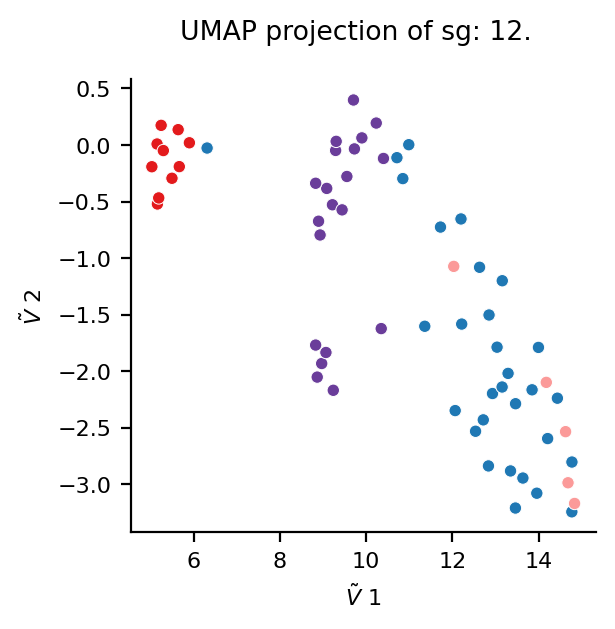

In [17]:
mpl.rc('font', size=8)

#############
sg = 1 # Choose which strain gague to plot
#############

markers = {"slow": "o", "fast": "^"}
fig, ax = plt.subplots(1,1,figsize=[3,3],dpi=200)
fig.patch.set_facecolor('white')
strain_gauge = 1
gauges = ['sg3','sg12','sg6','sgc','sg7','sg15']
sns.scatterplot(ax=ax,
                x=embedding[sg][:, 0],
                y=embedding[sg][:, 1],
#                 style=styles,
                c=[sns.color_palette(color_p,color_range)[x] for x in snow_types.map({'Icy':4, 'Groomer':1, 'Slushy':9, 'Powder':5})], s=20, markers=markers)

ax.legend([],[], frameon=False)
ax.set_xlabel(r"""$ \~V$""" + ' 1')
ax.set_ylabel(r"""$ \~V$""" + ' 2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#     ax.set_ylim(1,7)
fig.suptitle('UMAP projection of sg: 12.')
# plt.savefig("clusters_umap_ratio.svg",bbox_inches='tight',dpi=fig.dpi)
plt.show()

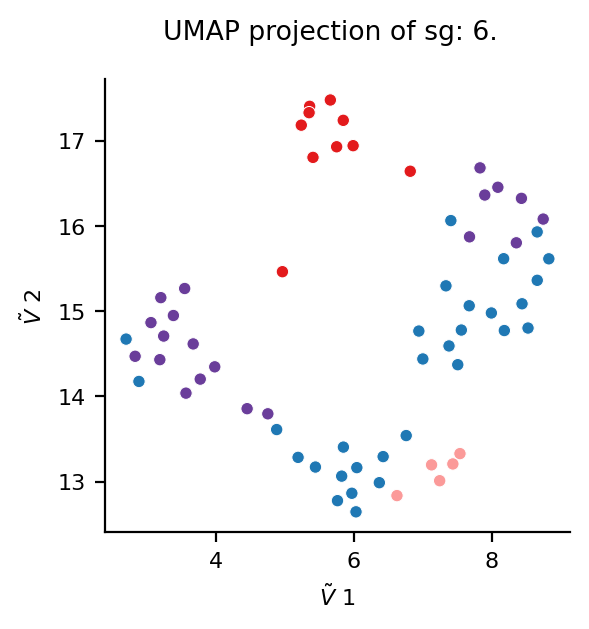

In [18]:
mpl.rc('font', size=8)

#############
sg = 2 # Choose which strain gague to plot
#############

markers = {"slow": "o", "fast": "^"}
fig, ax = plt.subplots(1,1,figsize=[3,3],dpi=200)
fig.patch.set_facecolor('white')
strain_gauge = 1
gauges = ['sg3','sg12','sg6','sgc','sg7','sg15']
sns.scatterplot(ax=ax,
                x=embedding[sg][:, 0],
                y=embedding[sg][:, 1],
#                 style=styles,
                c=[sns.color_palette(color_p,color_range)[x] for x in snow_types.map({'Icy':4, 'Groomer':1, 'Slushy':9, 'Powder':5})], s=20, markers=markers)

ax.legend([],[], frameon=False)
ax.set_xlabel(r"""$ \~V$""" + ' 1')
ax.set_ylabel(r"""$ \~V$""" + ' 2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#     ax.set_ylim(1,7)
fig.suptitle('UMAP projection of sg: 6.')
# plt.savefig("clusters_umap_ratio.svg",bbox_inches='tight',dpi=fig.dpi)
plt.show()

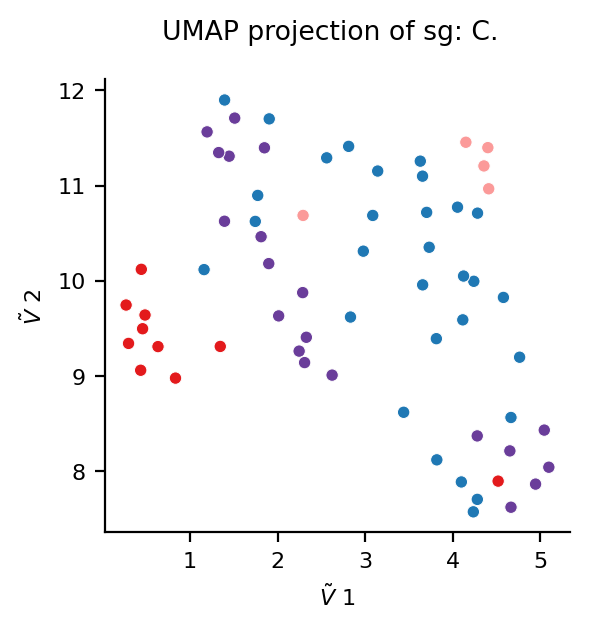

In [19]:
mpl.rc('font', size=8)

#############
sg = 3 # Choose which strain gague to plot
#############

markers = {"slow": "o", "fast": "^"}
fig, ax = plt.subplots(1,1,figsize=[3,3],dpi=200)
fig.patch.set_facecolor('white')
strain_gauge = 1
gauges = ['sg3','sg12','sg6','sgc','sg7','sg15']
sns.scatterplot(ax=ax,
                x=embedding[sg][:, 0],
                y=embedding[sg][:, 1],
#                 style=styles,
                c=[sns.color_palette(color_p,color_range)[x] for x in snow_types.map({'Icy':4, 'Groomer':1, 'Slushy':9, 'Powder':5})], s=20, markers=markers)

ax.legend([],[], frameon=False)
ax.set_xlabel(r"""$ \~V$""" + ' 1')
ax.set_ylabel(r"""$ \~V$""" + ' 2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#     ax.set_ylim(1,7)
fig.suptitle('UMAP projection of sg: C.')
# plt.savefig("clusters_umap_ratio.svg",bbox_inches='tight',dpi=fig.dpi)
plt.show()

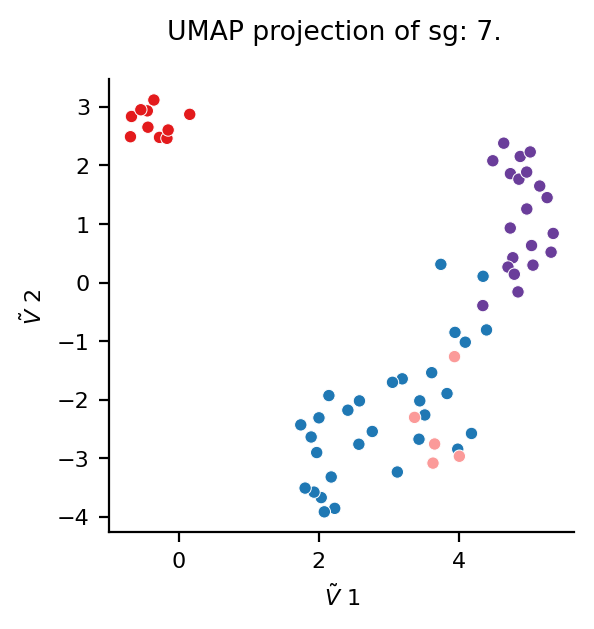

In [20]:
mpl.rc('font', size=8)

#############
sg = 4 # Choose which strain gague to plot
#############

markers = {"slow": "o", "fast": "^"}
fig, ax = plt.subplots(1,1,figsize=[3,3],dpi=200)
fig.patch.set_facecolor('white')
strain_gauge = 1
gauges = ['sg3','sg12','sg6','sgc','sg7','sg15']
sns.scatterplot(ax=ax,
                x=embedding[sg][:, 0],
                y=embedding[sg][:, 1],
#                 style=styles,
                c=[sns.color_palette(color_p,color_range)[x] for x in snow_types.map({'Icy':4, 'Groomer':1, 'Slushy':9, 'Powder':5})], s=20, markers=markers)

ax.legend([],[], frameon=False)
ax.set_xlabel(r"""$ \~V$""" + ' 1')
ax.set_ylabel(r"""$ \~V$""" + ' 2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#     ax.set_ylim(1,7)
fig.suptitle('UMAP projection of sg: 7.')
# plt.savefig("clusters_umap_ratio.svg",bbox_inches='tight',dpi=fig.dpi)
plt.show()

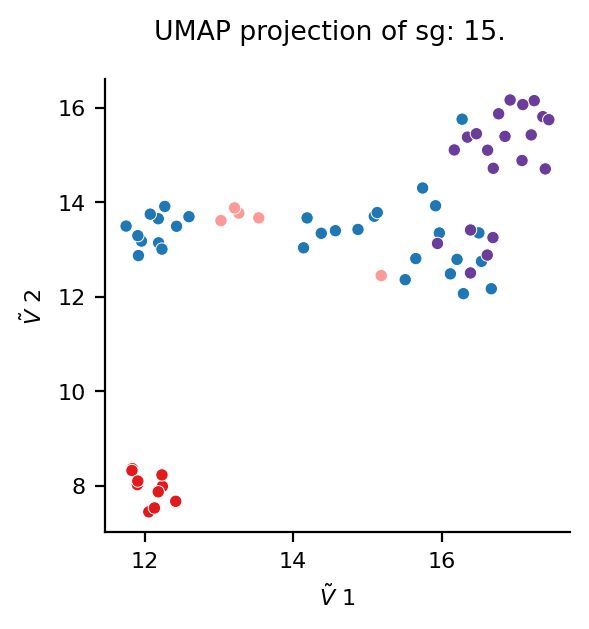

In [21]:
mpl.rc('font', size=8)

#############
sg = 5 # Choose which strain gague to plot
#############

markers = {"slow": "o", "fast": "^"}
fig, ax = plt.subplots(1,1,figsize=[3,3],dpi=200)
fig.patch.set_facecolor('white')
strain_gauge = 1
gauges = ['sg3','sg12','sg6','sgc','sg7','sg15']
sns.scatterplot(ax=ax,
                x=embedding[sg][:, 0],
                y=embedding[sg][:, 1],
#                 style=styles,
                c=[sns.color_palette(color_p,color_range)[x] for x in snow_types.map({'Icy':4, 'Groomer':1, 'Slushy':9, 'Powder':5})], s=20, markers=markers)

ax.legend([],[], frameon=False)
ax.set_xlabel(r"""$ \~V$""" + ' 1')
ax.set_ylabel(r"""$ \~V$""" + ' 2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#     ax.set_ylim(1,7)
fig.suptitle('UMAP projection of sg: 15.')
# plt.savefig("clusters_umap_ratio.svg",bbox_inches='tight',dpi=fig.dpi)
plt.show()

## 4.1.1 Try to find the centroid of each cluster

In [22]:
def find_centroid(df, column, snow_type):
    new_df = df[df[column] == snow_type]
    centroid = [np.average(new_df.iloc[:,0]),np.average(new_df.iloc[:,1])]
    return(centroid)
def find_centroid_not(df, column, snow_type):
    new_df = df[df[column] != snow_type[0]]
    new_df = new_df[new_df[column] != snow_type[1]]
    centroid = [np.average(new_df.iloc[:,0]),np.average(new_df.iloc[:,1])]
    return(centroid)

In [23]:
sg = 5
dist_pow_to_else = []
for i in range(0,6):

    data_sg0 = pd.DataFrame()
    data_sg0['col1'] = embedding[i][:,0]
    data_sg0['col2'] = embedding[i][:,1]
    data_sg0['label'] = snow_types.values

    cord_pow = find_centroid(data_sg0, 'label', 'Slushy')
    cord_not = find_centroid_not(data_sg0, 'label', ['Slushy','Powder'])

    dist = math.dist(cord_pow,cord_not)

    dist_pow_to_else.append(dist)


In [24]:
dist_pow_to_else

[3.956657612926928,
 3.7229389361218734,
 1.9147024883054142,
 0.9019758455134195,
 3.8776522839694265,
 2.978358909480589]

## 4.2 Scatter plots of dft of angular velocities

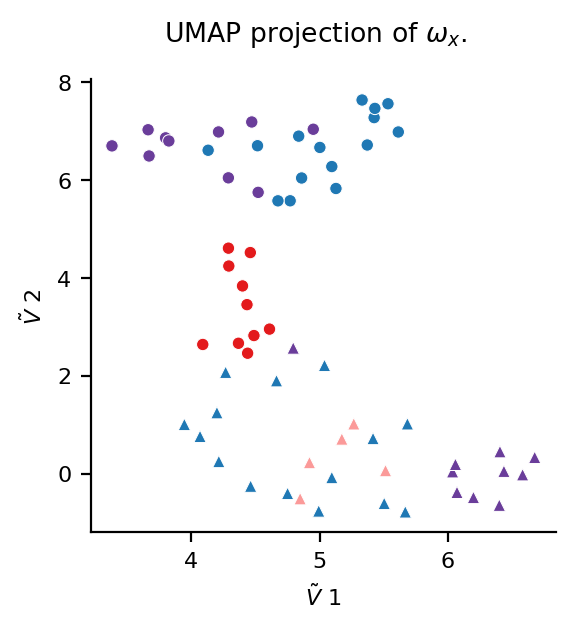

In [25]:
mpl.rc('font', size=8)

#############
sg = 5 # Choose which strain gague to plot
#############

markers = {"slow": "o", "fast": "^"}
fig, ax = plt.subplots(1,1,figsize=[3,3],dpi=200)
fig.patch.set_facecolor('white')
strain_gauge = 1
gauges = ['sg3','sg12','sg6','sgc','sg7','sg15']
sns.scatterplot(ax=ax,
                x=embedding_wx[:, 0],
                y=embedding_wx[:, 1],
                style=styles,
                c=[sns.color_palette(color_p,color_range)[x] for x in snow_types.map({'Icy':4, 'Groomer':1, 'Slushy':9, 'Powder':5})], s=20, markers=markers)

ax.legend([],[], frameon=False)
ax.set_xlabel(r"""$ \~V$""" + ' 1')
ax.set_ylabel(r"""$ \~V$""" + ' 2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#     ax.set_ylim(1,7)
fig.suptitle(r'UMAP projection of $\omega_x$.')
# plt.savefig("clusters_umap_ratio.svg",bbox_inches='tight',dpi=fig.dpi)
plt.show()

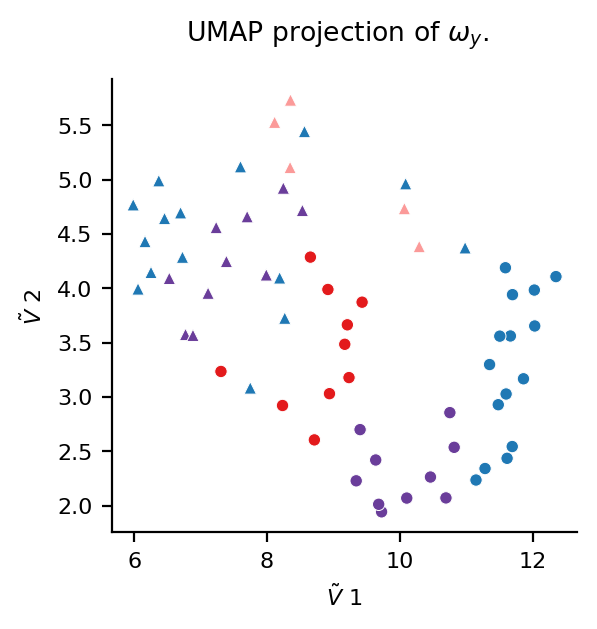

In [26]:
mpl.rc('font', size=8)

#############
sg = 5 # Choose which strain gague to plot
#############

markers = {"slow": "o", "fast": "^"}
fig, ax = plt.subplots(1,1,figsize=[3,3],dpi=200)
fig.patch.set_facecolor('white')
strain_gauge = 1
gauges = ['sg3','sg12','sg6','sgc','sg7','sg15']
sns.scatterplot(ax=ax,
                x=embedding_wy[:, 0],
                y=embedding_wy[:, 1],
                style=styles,
                c=[sns.color_palette(color_p,color_range)[x] for x in snow_types.map({'Icy':4, 'Groomer':1, 'Slushy':9, 'Powder':5})], s=20, markers=markers)

ax.legend([],[], frameon=False)
ax.set_xlabel(r"""$ \~V$""" + ' 1')
ax.set_ylabel(r"""$ \~V$""" + ' 2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#     ax.set_ylim(1,7)
fig.suptitle(r'UMAP projection of $\omega_y$.')
# plt.savefig("clusters_umap_ratio.svg",bbox_inches='tight',dpi=fig.dpi)
plt.show()

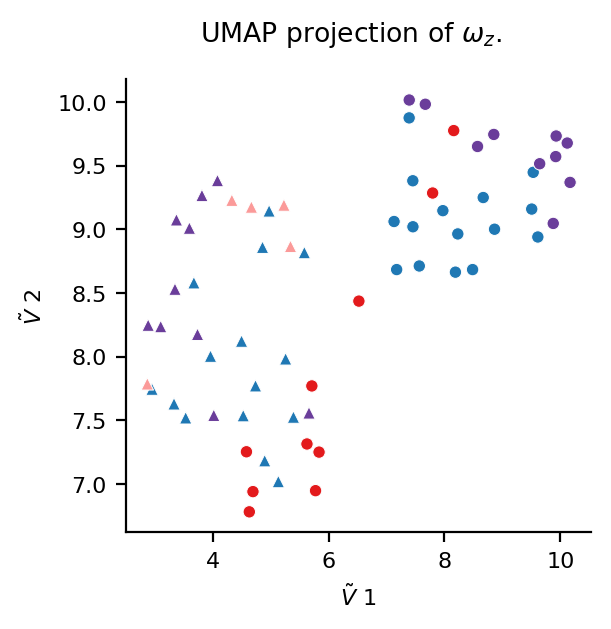

In [27]:
mpl.rc('font', size=8)

#############
sg = 5 # Choose which strain gague to plot
#############

markers = {"slow": "o", "fast": "^"}
fig, ax = plt.subplots(1,1,figsize=[3,3],dpi=200)
fig.patch.set_facecolor('white')
strain_gauge = 1
gauges = ['sg3','sg12','sg6','sgc','sg7','sg15']
sns.scatterplot(ax=ax,
                x=embedding_wz[:, 0],
                y=embedding_wz[:, 1],
                style=styles,
                c=[sns.color_palette(color_p,color_range)[x] for x in snow_types.map({'Icy':4, 'Groomer':1, 'Slushy':9, 'Powder':5})], s=20, markers=markers)

ax.legend([],[], frameon=False)
ax.set_xlabel(r"""$ \~V$""" + ' 1')
ax.set_ylabel(r"""$ \~V$""" + ' 2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#     ax.set_ylim(1,7)
fig.suptitle(r'UMAP projection of $\omega_z$.')
# plt.savefig("clusters_umap_ratio.svg",bbox_inches='tight',dpi=fig.dpi)
plt.show()

## 4.3 Scatter plots of dft of strain gagues

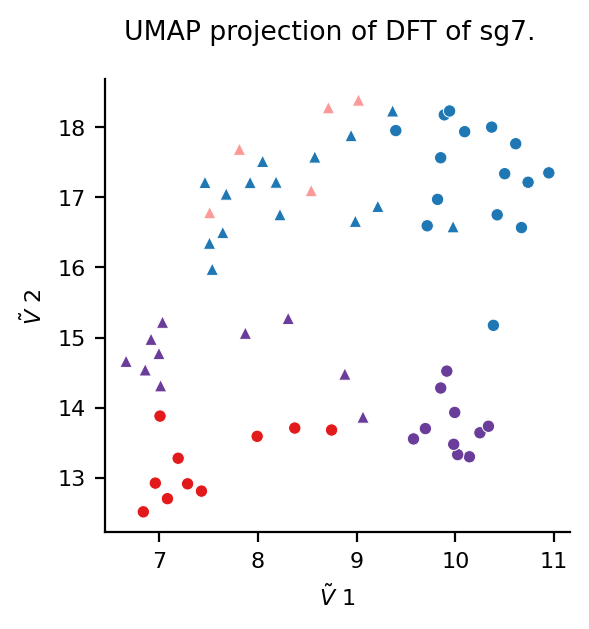

In [28]:
mpl.rc('font', size=8)

#############
sg = 5 # Choose which strain gague to plot
#############

markers = {"slow": "o", "fast": "^"}
fig, ax = plt.subplots(1,1,figsize=[3,3],dpi=200)
fig.patch.set_facecolor('white')
strain_gauge = 1
gauges = ['sg3','sg12','sg6','sgc','sg7','sg15']
sns.scatterplot(ax=ax,
                x=embedding7_original[:, 0],
                y=embedding7_original[:, 1],
                style=styles,
                c=[sns.color_palette(color_p,color_range)[x] for x in snow_types.map({'Icy':4, 'Groomer':1, 'Slushy':9, 'Powder':5})], s=20, markers=markers)

ax.legend([],[], frameon=False)
ax.set_xlabel(r"""$ \~V$""" + ' 1')
ax.set_ylabel(r"""$ \~V$""" + ' 2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#     ax.set_ylim(1,7)
fig.suptitle(r'UMAP projection of DFT of sg7.')
# plt.savefig("clusters_umap_ratio.svg",bbox_inches='tight',dpi=fig.dpi)
plt.show()